In [1]:
from matplotlib import pyplot as plt
import random
import imghdr
import cv2
import tensorflow as tf
import warnings
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output
import os

# Bringing in tensorflow

IMG_SIZE = 224

DATADIR = 'new_data/train'

CATEGORIES = ['asd', 'normal']

training_data = []


def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        os.makedirs(path, exist_ok=True)
        class_num = CATEGORIES.index(category)
        names = os.listdir(path)
        for img in names:
            try:
                img_array = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass


create_training_data()

DATADIR = 'new_data/test'

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        os.makedirs(path, exist_ok=True)
        class_num = CATEGORIES.index(category)
        names = os.listdir(path)
        for img in names:
            try:
                img_array = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass


create_testing_data()

random.shuffle(training_data)

X = []  # features
y = []  # labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.asarray(y)

print(len(y))


6881


In [2]:
X = X/255
y = np.asarray(y).astype('float32').reshape((-1, 1))
# X = X[:, :, :, :3]
print(X.shape)
print(y.shape)

(6881, 224, 224)
(6881, 1)


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(4816, 224, 224) (2065, 224, 224)
(4816, 1) (2065, 1)


In [5]:
import tensorflow
import tensorflow as keras
from keras.models import Sequential
# from keras.layers import concatenate
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization
from tensorflow_addons.layers import MultiHeadAttention
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
# from keras import backend as K
# import keras
from keras.layers import UpSampling2D, BatchNormalization, LeakyReLU, Reshape, Add, Concatenate
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers import MaxPooling2D, GlobalAveragePooling2D 

def se_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    return tf.keras.layers.multiply([in_block, x])

INPUT_SHAPE = (224, 224, 1)   #change to (SIZE, SIZE, 3)

input = Input(shape=INPUT_SHAPE)


x = Conv2D(32, kernel_size=(2,2), padding='same', kernel_initializer = 'he_uniform')(input)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, kernel_size=(2,2), padding='same', kernel_initializer = 'he_uniform')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

res = x

x = LeakyReLU(0.2)(x)

x = Dropout(0.3)(x)

x = Conv2D(128, kernel_size=(2,2), padding='same', kernel_initializer = 'he_uniform')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = MaxPooling2D()(x)

x = Conv2D(128, kernel_size=(2,2), padding='same', kernel_initializer = 'he_uniform')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

res = Conv2D(128, kernel_size=(2,2), padding='same', kernel_initializer = 'he_uniform')(res)
res = BatchNormalization()(res)
res = MaxPooling2D()(res)


x = Add()([x,res])
b,h,w,c=x.shape
x = se_block(x,c)

# x = tf.keras.layers.MultiHeadAttention(num_heads = 5,key_dim = 8,dropout=0.2)(x,x)

x = LeakyReLU(0.2)(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)



x = Flatten()(x)
output = x

# x = Dense(128, kernel_initializer = 'he_uniform')(x)
# x = LeakyReLU(0.2)(x)
# x = Dense(32, kernel_initializer = 'he_uniform')(x)
# output = Dense(1, activation = 'sigmoid')(x)


model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 224, 224, 32)         160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 224, 224, 32)         128       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 224, 224, 32)         0         ['batch_normalization_5[0]

In [6]:
X_for_RF = model.predict(x_train) #This is out X input to RF78

151/151 [==============================] - 117s 768ms/step


In [7]:
from sklearn.ensemble import RandomForestClassifier 
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
history = RF_model.fit(X_for_RF, y_train)

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [8]:
feature = model.predict(x_test)
pred = RF_model.predict(feature)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, pred))

65/65 [==============================] - 55s 843ms/step
Accuracy =  0.9859564164648911


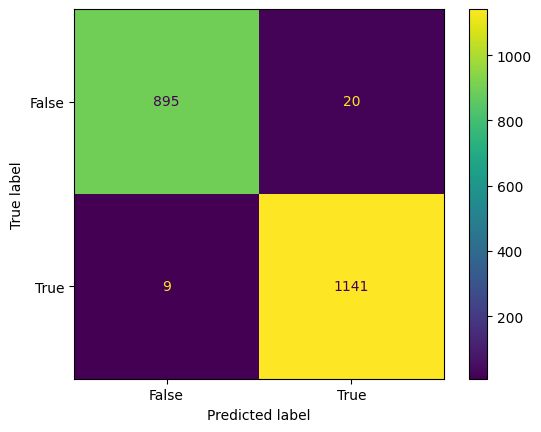

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       915
         1.0       0.98      0.99      0.99      1150

    accuracy                           0.99      2065
   macro avg       0.99      0.99      0.99      2065
weighted avg       0.99      0.99      0.99      2065

Sensitivity =  0.9781420765027322
Specificity =  0.9921739130434782
AUC score =  0.985


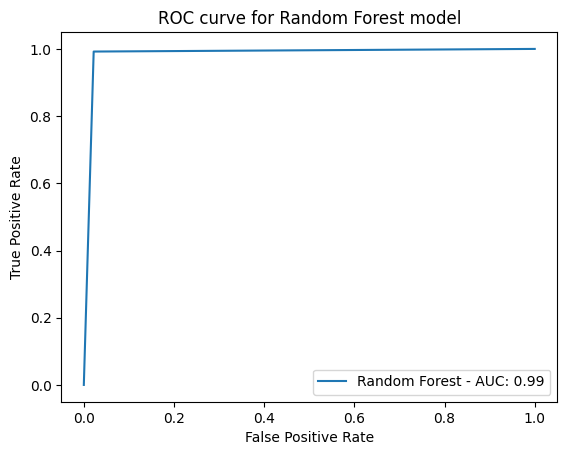

In [9]:
confusion_matrix = metrics.confusion_matrix(y_test, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

print(metrics.classification_report(y_test, pred)) 

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print("Sensitivity = ", sensitivity)

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print("Specificity = ", specificity)

from sklearn.metrics import roc_auc_score
auc = np.round(roc_auc_score(y_test, pred),3)
print("AUC score = ", auc)

from sklearn.metrics import roc_curve, auc
import pandas as pd
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = f"Random Forest - AUC: {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest model")
plt.legend()
plt.show()

In [10]:
X_for_LR = X_for_RF
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_for_LR, y_train)

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
feature_LR = model.predict(x_test)
pred_LR = log_reg.predict(feature_LR)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, pred_LR))

65/65 [==============================] - 53s 810ms/step
Accuracy =  0.8261501210653753


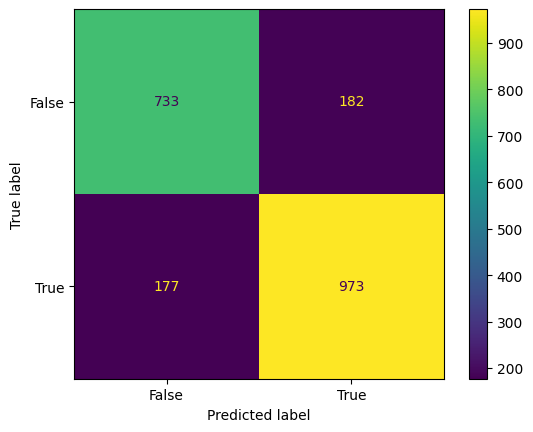

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       915
         1.0       0.84      0.85      0.84      1150

    accuracy                           0.83      2065
   macro avg       0.82      0.82      0.82      2065
weighted avg       0.83      0.83      0.83      2065

Sensitivity =  0.8010928961748633
Specificity =  0.8460869565217392
AUC score =  0.824


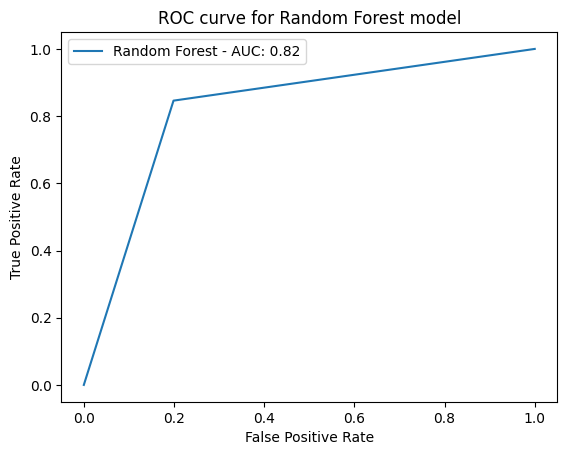

In [12]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_LR)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

print(metrics.classification_report(y_test, pred_LR)) 

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print("Sensitivity = ", sensitivity)

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print("Specificity = ", specificity)

from sklearn.metrics import roc_auc_score
auc = np.round(roc_auc_score(y_test, pred_LR),3)
print("AUC score = ", auc)

from sklearn.metrics import roc_curve, auc
import pandas as pd
fpr, tpr, _ = roc_curve(y_test, pred_LR)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = f"Random Forest - AUC: {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest model")
plt.legend()
plt.show()

In [13]:
X_for_KNN = X_for_RF

from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()

knn.fit(X_for_RF, y_train)

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [14]:
# feature_KNN = model.predict(x_test)
pred_KNN = knn.predict(feature)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, pred_KNN))

Accuracy =  0.9767554479418886


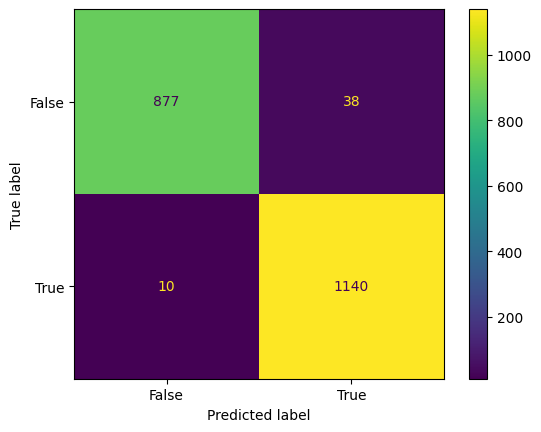

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       915
         1.0       0.97      0.99      0.98      1150

    accuracy                           0.98      2065
   macro avg       0.98      0.97      0.98      2065
weighted avg       0.98      0.98      0.98      2065

Sensitivity =  0.9584699453551913
Specificity =  0.991304347826087
AUC score =  0.975


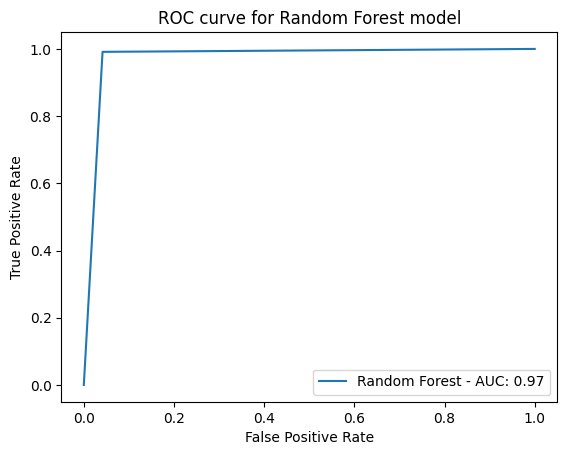

In [15]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_KNN)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

print(metrics.classification_report(y_test, pred_KNN)) 

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print("Sensitivity = ", sensitivity)

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print("Specificity = ", specificity)

from sklearn.metrics import roc_auc_score
auc = np.round(roc_auc_score(y_test, pred_KNN),3)
print("AUC score = ", auc)

from sklearn.metrics import roc_curve, auc
import pandas as pd
fpr, tpr, _ = roc_curve(y_test, pred_KNN)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = f"Random Forest - AUC: {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest model")
plt.legend()
plt.show()